# Plot correlations between predictors
For each experiment, check potential correlations between predictors: stimulus intensity, opto light, pupil size, run speed.

1. Plot predictor correlation matrix to explore overall patterns.
  - e.g. pupil size related to stim luminance (pupil light reflex)?
  - e.g. running related to stimulus luminance?
  - e.g. pupil diameter and run speed correlated?
  - e.g. pupil size related to opto light (i.e. light artefact?)
2. Check cross-correlations to see potential delays in correlations (e.g. pupil light reflex to stimulus intensity), and then correlate the predictor traces using the found delays.

# Setup

In [1]:
run -im djd.main -- --dbname=dj_hmov

Connecting write@huxley.neuro.bzm:3306
Connected to database 'dj_hmov' as 'write@10.153.173.165'


In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import pprint
import scipy
import seaborn as sns
import warnings
# warnings.filterwarnings("ignore")

# DJD modules
from djd.hmov_unit import corr_predictors, predictor_corr_matrix
from djd.util import cm2inch
from djd.plot import adjust_spines, get_color_dict

In [59]:
## Update plot parameters
# Option 1: Update general pars from modified matplotlibrc file
plt.rcParams.update(mpl.rc_params_from_file('../../matplotlibrc', fail_on_error=False, use_default_template=True))

# Option 2: Dynamically update general pars (use if not updating from modified matplotlibrc)
plt.rcParams.update({
#     'figure.dpi': 100,
    'figure.max_open_warning': 0, 
    'axes.labelsize': 'medium',
    'font.sans-serif': ['Arial'],
    'pdf.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    'ps.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    })

# Dynamically update plot-specific pars
plt.rcParams.update({
#     'figure.dpi': 100,
    'figure.max_open_warning': 0, 
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
#     'ytick.major.pad': 1, # 3.5
    'axes.labelsize': 7.0,
    'axes.titlesize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    })

# Get default colors for opto, locomotion and eye data
col_dict = get_color_dict(color_names=['blue','orange', 'green', 'red', 'purple',
                                       'brown', 'pink', 'gray', 'yellow', 'lightblue'])
cols = {'opto': col_dict['blue'],
        'run': col_dict['green'],
        'eye': col_dict['orange'],
        }

# Get unit keys

In [4]:
df = pd.DataFrame((Series.Experiment() & HmovUnit()).fetch(dj.key, as_dict=True))
df

,m,s,e
0,Ntsr1Cre_2019_0007,6,9
1,Ntsr1Cre_2019_0008,3,7
2,Ntsr1Cre_2019_0008,5,8
3,Ntsr1Cre_2019_0008,6,6
4,Ntsr1Cre_2019_0008,7,6
5,Ntsr1Cre_2020_0001,2,7
6,Ntsr1Cre_2020_0001,3,6
7,Ntsr1Cre_2020_0001,3,10
8,Ntsr1Cre_2020_0002,3,6
9,Ntsr1Cre_2020_0002,4,8


# Plot predictor correlation matrix
First check of any patterns

In [57]:
err_list = []
dfs = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:        
        df_corr = predictor_corr_matrix(key) # -0.384
        dfs.append(df_corr.values)
        print('.', end='')
    except:
        print('x', end='')
        err_list.append(key)
        continue

mean_corr = np.array(dfs).mean(axis=0)
df_mean_corr = pd.DataFrame(mean_corr, columns=df_corr.columns, index=df_corr.index)

print('\nError list:')
pprint.pprint(err_list)

...xxxxx...
Error list:
[{'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 6},
 {'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 7},
 {'e': 7, 'm': 'Ntsr1Cre_2020_0001', 's': 2},
 {'e': 6, 'm': 'Ntsr1Cre_2020_0001', 's': 3},
 {'e': 10, 'm': 'Ntsr1Cre_2020_0001', 's': 3}]


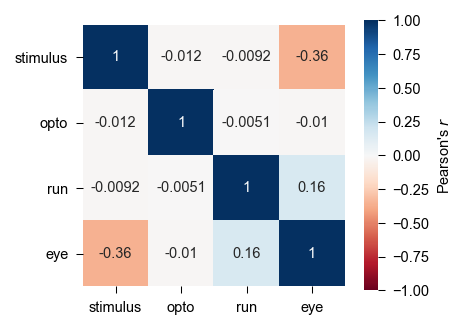

In [75]:
fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax = sns.heatmap(df_mean_corr, cmap='RdBu', center=0, vmin=-1, vmax=1, square=True,
                 annot=True, annot_kws={'fontsize': 7},
                 cbar_kws={'label': "Pearson's $r$", 'shrink':0.6},
                 ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(axis='y', rotation=0)

As expected, it looks like stimulus intensity and pupil size are negatively correlated,
and pupil size and run speed are positively correlated.
opto light and other predictors are independent, so we can likely exclude artefacts from opto light having an effect on the other predictors.

# Check predictors against one another - check Xcorrs and then correlations
Doing so for interesting candidates only.

## Pupil size vs stimulus luminance

### Get cross-correlation
To find out delay of pupil light reflex to stimulus luminance.

In [155]:
# Get cross corr for individual experiments
corrs = []
lags = []
err_list = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:
        corr, lag = corr_predictors(key, 'eye', 'stim', 
                                    kind='cross-corr')
        corrs.append(corr), lags.append(lag)
        print('.', end='')
    except:
        print('x', end='')
        err_list.append(key)
        continue
print('\nError list:')
pprint.pprint(err_list)

...xxxxx...
Error list:
[{'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 6},
 {'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 7},
 {'e': 7, 'm': 'Ntsr1Cre_2020_0001', 's': 2},
 {'e': 6, 'm': 'Ntsr1Cre_2020_0001', 's': 3},
 {'e': 10, 'm': 'Ntsr1Cre_2020_0001', 's': 3}]


In [156]:
# Unify experiment-wise cross-corrs of different length into single array
minlag = np.min([i[-1] for i in lags])  # find experiment w smallest lag range
print('minlag = ±', minlag, 's')

# Apply minlag to all experiments to get same trange
for i, l in enumerate(lags):
    corrs[i] = corrs[i][(l >= -minlag) & (l <= minlag)]
    lags[i] = lags[i][(l >= -minlag) & (l <= minlag)]

corrs = np.stack(corrs)
lags = np.stack(lags)

corrs_mean = np.mean(corrs, axis=0)

minlag = ± 1624.2333333333333 s


### Plot cross-correlation

Text(0, 0.5, 'Normalized cross-correlation')

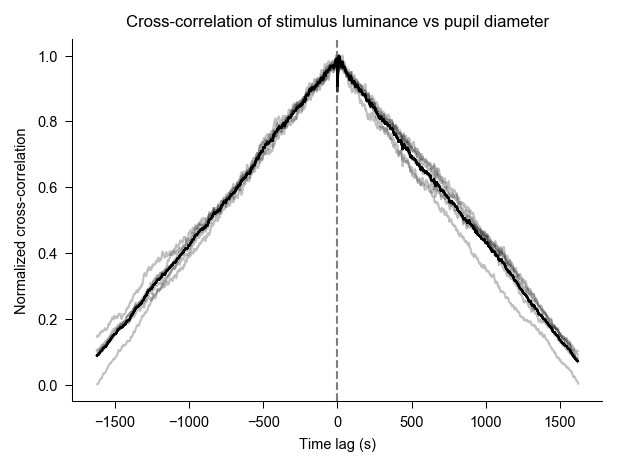

In [157]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(lags.T, corrs.T, 'k', alpha=0.25)
plt.plot(lags.T, corrs_mean, 'k')
ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
# maxcorr = lags[np.where(corr == np.max(corr))[0]]  # find max crosscorr
# ax.axvline(x=maxcorr, ymin=0, ymax=1, color='r', linestyle='--', zorder=-1)
# ax.set_xlim([-1,1])
ax.set_title('Cross-correlation of stimulus luminance vs pupil diameter')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized cross-correlation')  # 'Discrete lin cross-corr'

### Find minimum cross-corr within defined centre time range
-> This identifies the time lag between stim luminance increase and pupil constriction by finding the delayed negative peak of the Xcorr 

In [158]:
trange = [-5, 5]
lags_range = lags[0][(lags[0] >= trange[0]) & (lags[0] < trange[-1])]
corrs_range = corrs_mean[(lags[0] >= trange[0]) & (lags[0] < trange[-1])]
mincorr = corrs_range[np.where(corrs_range == np.min(corrs_range))[0]]  # find min crosscorr
mincorr_t = lags_range[np.where(corrs_range == np.min(corrs_range))[0]]  # find min crosscorr tpoint
mincorr_t

array([0.66666667])

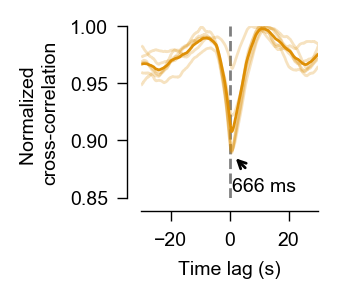

In [159]:
## Plot stimulus-pupil diameter cross-correlation

fig, ax = plt.subplots(figsize=cm2inch((4,3.5)), dpi=200)

ax.plot(lags.T, corrs.T, color=cols['eye'], alpha=0.25)
ax.plot(lags[0], corrs_mean, color=col)

ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
ax.annotate(f'{np.int(mincorr_t[0]*1000)} ms', xy=(mincorr_t, mincorr-0.02), 
            xytext=(mincorr_t, mincorr-0.04), ha='left', va='top', size=7,
            arrowprops=dict(facecolor='black', arrowstyle='->', relpos=(0.5,0.5)))# width=0.05, shrink=0.5))
ax.set_xlim([-30, 30])
ax.set_ylim([0.85,1])
# ax.set_title('Cross-correlation of \nstimulus luminance vs pupil diameter')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized \ncross-correlation')  # 'Discrete lin cross-corr'

adjust_spines(ax, ['bottom', 'left'])

plt.savefig('eye_stim_luminance_cross_corr.pdf')

### Get pupil size vs stimulus luminance correlation
Now shifting the eye traces by the pupil reflex delay time.

In [160]:
corrs = np.full(len(df), np.nan)
pvals = np.full(len(df), np.nan)
corrs_null = np.full((len(df),1000), np.nan)
err_list = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:
        corrs[i], pvals[i], corrs_null[i,:] = corr_predictors(key, 'eye', 'stim',
                                                              kind='pearsonr', 
                                                              shift_eye_t=-0.666) # -0.384
        print('.', end='')
    except:
        print('x', end='')
        err_list.append(key)
        continue

# Remove NaNs
pvals = pvals[~np.isnan(corrs)]
corrs_null = corrs_null[~np.isnan(corrs)]
corrs = corrs[~np.isnan(corrs)]
print('\nError list:')
pprint.pprint(err_list)

...xxxxx...
Error list:
[{'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 6},
 {'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 7},
 {'e': 7, 'm': 'Ntsr1Cre_2020_0001', 's': 2},
 {'e': 6, 'm': 'Ntsr1Cre_2020_0001', 's': 3},
 {'e': 10, 'm': 'Ntsr1Cre_2020_0001', 's': 3}]


### Check stats

In [161]:
# Check how many p-vals are significant (two-tailed)
print('Correlation coeffs:\n', np.round(corrs, 3))
print(f'Mean ± SD:\n {np.mean(corrs)} ± {np.std(corrs)}')

alpha = 0.001
signif = sum((pvals < alpha) | (pvals > 1-alpha))
print(f'Significant values with p < {alpha}:\n {signif}/{len(pvals)}')

Correlation coeffs:
 [-0.339 -0.593 -0.252 -0.411 -0.257 -0.585]
Mean ± SD:
 -0.40606052822533006 ± 0.13985149771563382
Significant values with p < 0.001:
 6/6


### Plot correlation

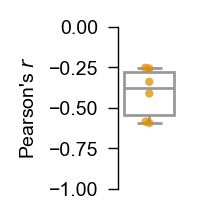

In [162]:
## Plot stim-pupil correlations

fig, ax = plt.subplots(figsize=cm2inch((2.25,2.5)), dpi=200)
sns.boxplot(y=corrs, ax=ax, color='w')#, zorder=-1)
sns.swarmplot(y=corrs, color=cols['eye'], edgecolor=col, size=3, alpha=0.75, ax=ax)
# ax.set_title(f'Correlation of stimulus luminance vs pupil diameter\n n$_{{exp}}$={len(corrs)}')
ax.set_ylabel("Pearson's $r$")

ax.set_ylim([-1,0])
ax.spines['bottom'].set_visible(False)
plt.setp(ax.xaxis.get_ticklines(), color='none')

plt.savefig('eye_stim_luminance_corr.pdf')

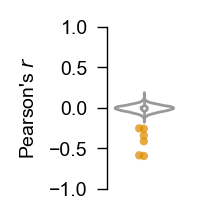

In [163]:
## Plot stim-pupil correlations

fig, ax = plt.subplots(figsize=cm2inch((2.25,2.5)), dpi=200)
sns.violinplot(y=np.hstack(corrs_null), color='w', label='null', ax=ax)#, zorder=-1)
# sns.boxplot(y=corrs, ax=ax, color='w')#, zorder=-1)
sns.swarmplot(y=corrs, color=col, edgecolor=cols['eye'], size=3, alpha=0.75, label='true', ax=ax)
# ax.set_title(f'Correlation of stimulus luminance vs pupil diameter\n n$_{{exp}}$={len(corrs)}')
ax.set_ylabel("Pearson's $r$")
# ax.legend()

ax.set_ylim([-1,1])
ax.spines['bottom'].set_visible(False)
plt.setp(ax.xaxis.get_ticklines(), color='none')

plt.savefig('eye_stim_luminance_corr_vs_null.pdf')

## pupil size vs run speed

### Cross-correlation

In [101]:
# Get cross corr for individual experiments
corrs = []
lags = []
err_list = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:
        corr, lag = corr_predictors(key, 'eye', 'run', 
                                    kind='cross-corr')
        corrs.append(corr), lags.append(lag)
        print('.', end='')
    except:
        print('x', end='')
        err_list.append(key)
        continue
print('\nError list:')
pprint.pprint(err_list)

...xxxxx...
Error list:
[{'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 6},
 {'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 7},
 {'e': 7, 'm': 'Ntsr1Cre_2020_0001', 's': 2},
 {'e': 6, 'm': 'Ntsr1Cre_2020_0001', 's': 3},
 {'e': 10, 'm': 'Ntsr1Cre_2020_0001', 's': 3}]


In [102]:
# Unify experiment-wise cross-corrs of different length into single array
minlag = np.min([i[-1] for i in lags])  # find experiment w smallest lag range
print('minlag = ±', minlag, 's')

# Apply minlag to all experiments to get same trange
for i, l in enumerate(lags):
    corrs[i] = corrs[i][(l >= -minlag) & (l <= minlag)]
    lags[i] = lags[i][(l >= -minlag) & (l <= minlag)]

corrs = np.stack(corrs)
lags = np.stack(lags)

corrs_mean = np.mean(corrs, axis=0)

minlag = ± 1624.2333333333333 s


Text(0, 0.5, 'Normalized cross-correlation')

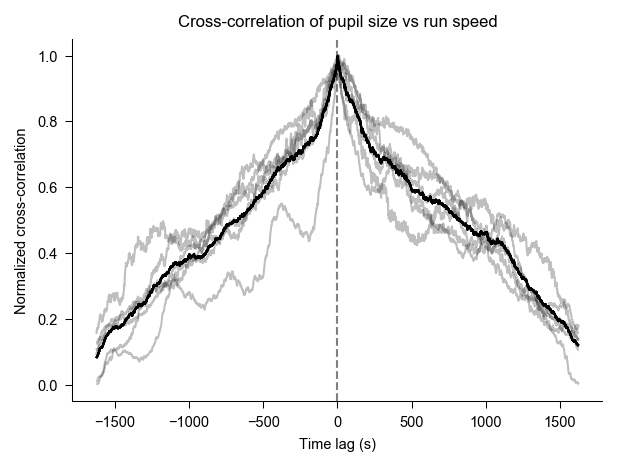

In [103]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(lags.T, corrs.T, 'k', alpha=0.25)
plt.plot(lags.T, corrs_mean, 'k')
ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
# maxcorr = lags[np.where(corr == np.max(corr))[0]]  # find max crosscorr
# ax.axvline(x=maxcorr, ymin=0, ymax=1, color='r', linestyle='--', zorder=-1)
# ax.set_xlim([-1,1])
ax.set_title('Cross-correlation of pupil size vs run speed')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized cross-correlation')  # 'Discrete lin cross-corr'

### Find maximum cross-corr within defined centre time range
-> This identifies the time lag between pupil size and run speed by finding the extremum of the xcorr 

In [104]:
trange = [-50, 50]
lags_range = lags[0][(lags[0] >= trange[0]) & (lags[0] < trange[-1])]
corrs_range = corrs_mean[(lags[0] >= trange[0]) & (lags[0] < trange[-1])]
maxcorr = corrs_range[np.where(corrs_range == np.max(corrs_range))[0]]  # find max crosscorr
maxcorr_t = lags_range[np.where(corrs_range == np.max(corrs_range))[0]]  # find max crosscorr tpoint
maxcorr_t

array([1.4])

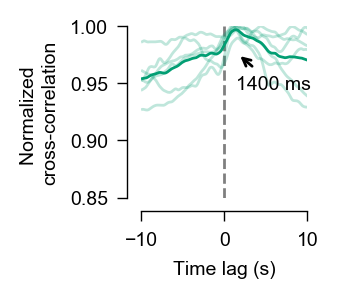

In [105]:
## Plot stimulus-pupil diameter cross-correlation

fig, ax = plt.subplots(figsize=cm2inch((4,3.5)), dpi=200)

ax.plot(lags.T, corrs.T, color=cols['run'], alpha=0.25)
ax.plot(lags[0], corrs_mean, color=cols['run'])

ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
ax.annotate(f'{np.int(maxcorr_t[0]*1000)} ms', xy=(maxcorr_t, maxcorr-0.02), 
            xytext=(maxcorr_t, maxcorr-0.04), ha='left', va='top', size=7,
            arrowprops=dict(facecolor='black', arrowstyle='->', relpos=(0.5,0.5)))# width=0.05, shrink=0.5))
ax.set_xlim([-10, 10])
ax.set_ylim([0.85,1])
# ax.set_title('Cross-correlation of \nstimulus luminance vs pupil diameter')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized \ncross-correlation')  # 'Discrete lin cross-corr'

adjust_spines(ax, ['bottom', 'left'])

# plt.savefig('eye_stim_luminance_cross_corr.pdf')

### Get pupil size vs run speed correlation
Now shifting the eye traces by the found delay time.

In [108]:
corrs = np.full(len(df), np.nan)
pvals = np.full(len(df), np.nan)
corrs_null = np.full((len(df),1000), np.nan)
err_list = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:
        corrs[i], pvals[i], corrs_null[i,:] = corr_predictors(key, 'eye', 'run',
                                                              kind='pearsonr',
                                                              shift_eye_t=-1.4)
        print('.', end='')
    except:
        print('x', end='')
        err_list.append(key)
        continue

# Remove NaNs
pvals = pvals[~np.isnan(corrs)]
corrs_null = corrs_null[~np.isnan(corrs)]
corrs = corrs[~np.isnan(corrs)]
print('\nError list:')
pprint.pprint(err_list)

...xxxxx...
Error list:
[{'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 6},
 {'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 7},
 {'e': 7, 'm': 'Ntsr1Cre_2020_0001', 's': 2},
 {'e': 6, 'm': 'Ntsr1Cre_2020_0001', 's': 3},
 {'e': 10, 'm': 'Ntsr1Cre_2020_0001', 's': 3}]


### Check stats

In [109]:
# Check how many p-vals are significant (two-tailed)
print('Correlation coeffs:\n', np.round(corrs, 3))
print(f'Mean corr coeff ± SD:\n {np.mean(corrs)} ± {np.std(corrs)}')

alpha = 0.001
signif = sum((pvals < alpha) | (pvals > 1-alpha))
print(f'Significant values with p < {alpha}:'
      f'\n {pvals}',
      f'\n => {signif}/{len(pvals)}')

Correlation coeffs:
 [0.57  0.169 0.077 0.187 0.011 0.135]
Mean corr coeff ± SD:
 0.1914745376349364 ± 0.17925402512011787
Significant values with p < 0.001:
 [1.    1.    0.999 1.    0.647 1.   ] 
 => 5/6


## Stimulus vs run speed

### Cross-correlation

In [39]:
# Get cross corr for individual experiments
corrs = []
lags = []
err_list = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:
        corr, lag = corr_predictors(key, 'stim', 'run', 
                                    kind='cross-corr')
        corrs.append(corr), lags.append(lag)
        print('.', end='')
    except:
        print('x', end='')
        err_list.append(key)
        continue
print('\nError list:')
pprint.pprint(err_list)

...xxxxx...
Error list:
[{'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 6},
 {'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 7},
 {'e': 7, 'm': 'Ntsr1Cre_2020_0001', 's': 2},
 {'e': 6, 'm': 'Ntsr1Cre_2020_0001', 's': 3},
 {'e': 10, 'm': 'Ntsr1Cre_2020_0001', 's': 3}]


In [40]:
# Unify experiment-wise cross-corrs of different length into single array
minlag = np.min([i[-1] for i in lags])  # find experiment w smallest lag range
print('minlag = ±', minlag, 's')

# Apply minlag to all experiments to get same trange
for i, l in enumerate(lags):
    corrs[i] = corrs[i][(l >= -minlag) & (l <= minlag)]
    lags[i] = lags[i][(l >= -minlag) & (l <= minlag)]

corrs = np.stack(corrs)
lags = np.stack(lags)

corrs_mean = np.mean(corrs, axis=0)

minlag = ± 1799.9666666666667 s


Text(0, 0.5, 'Normalized cross-correlation')

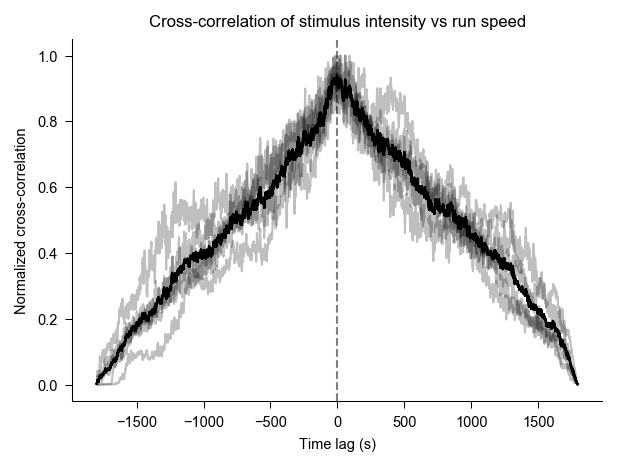

In [41]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(lags.T, corrs.T, 'k', alpha=0.25)
plt.plot(lags.T, corrs_mean, 'k')
ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
# maxcorr = lags[np.where(corr == np.max(corr))[0]]  # find max crosscorr
# ax.axvline(x=maxcorr, ymin=0, ymax=1, color='r', linestyle='--', zorder=-1)
# ax.set_xlim([-1,1])
ax.set_title('Cross-correlation of stimulus intensity vs run speed')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized cross-correlation')  # 'Discrete lin cross-corr'

### Find maximum cross-corr within defined centre time range
-> This identifies the time lag between stimulus luminance and run speed by finding the extremum of the xcorr 

In [48]:
trange = [-50, 50]
lags_range = lags[0][(lags[0] >= trange[0]) & (lags[0] < trange[-1])]
corrs_range = corrs_mean[(lags[0] >= trange[0]) & (lags[0] < trange[-1])]
maxcorr = corrs_range[np.where(corrs_range == np.max(corrs_range))[0]]  # find max crosscorr
maxcorr_t = lags_range[np.where(corrs_range == np.max(corrs_range))[0]]  # find max crosscorr tpoint
maxcorr_t

array([-1.8])

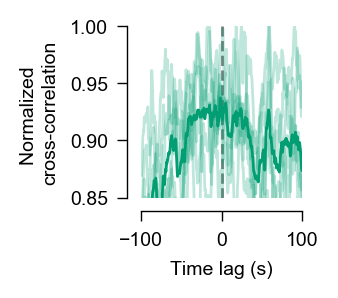

In [53]:
## Plot stimulus-pupil diameter cross-correlation

fig, ax = plt.subplots(figsize=cm2inch((4,3.5)), dpi=200)

ax.plot(lags.T, corrs.T, color=cols['run'], alpha=0.25)
ax.plot(lags[0], corrs_mean, color=cols['run'])

ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
# ax.annotate(f'{np.int(maxcorr_t[0]*1000)} ms', xy=(maxcorr_t, maxcorr-0.02), 
#             xytext=(maxcorr_t, maxcorr-0.04), ha='left', va='top', size=7,
#             arrowprops=dict(facecolor='black', arrowstyle='->', relpos=(0.5,0.5)))# width=0.05, shrink=0.5))
ax.set_xlim([-100, 100])
ax.set_ylim([0.85,1])
# ax.set_title('Cross-correlation of \nstimulus luminance vs pupil diameter')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized \ncross-correlation')  # 'Discrete lin cross-corr'

adjust_spines(ax, ['bottom', 'left'])

# plt.savefig('eye_stim_luminance_cross_corr.pdf')

### Get run speed vs stimulus luminance correlation
Now shifting the eye traces by the pupil reflex delay time.

In [76]:
corrs = np.full(len(df), np.nan)
pvals = np.full(len(df), np.nan)
corrs_null = np.full((len(df),1000), np.nan)
err_list = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:
        corrs[i], pvals[i], corrs_null[i,:] = corr_predictors(key, 'run', 'stim',
                                                              kind='pearsonr')
        print('.', end='')
    except:
        print('x', end='')
        err_list.append(key)
        continue

# Remove NaNs
pvals = pvals[~np.isnan(corrs)]
corrs_null = corrs_null[~np.isnan(corrs)]
corrs = corrs[~np.isnan(corrs)]
print('\nError list:')
pprint.pprint(err_list)

...xxxxx...
Error list:
[{'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 6},
 {'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 7},
 {'e': 7, 'm': 'Ntsr1Cre_2020_0001', 's': 2},
 {'e': 6, 'm': 'Ntsr1Cre_2020_0001', 's': 3},
 {'e': 10, 'm': 'Ntsr1Cre_2020_0001', 's': 3}]


### Check stats

In [87]:
# Check how many p-vals are significant (two-tailed)
print('Correlation coeffs:\n', np.round(corrs, 3))
print(f'Mean corr coeff ± SD:\n {np.mean(corrs)} ± {np.std(corrs)}')

alpha = 0.001
signif = sum((pvals < alpha) | (pvals > 1-alpha))
print(f'Significant values with p < {alpha}:'
      f'\n{pvals}',
      f'\n => {signif}/{len(pvals)}')

Correlation coeffs:
 [ 0.017  0.001 -0.005 -0.013 -0.    -0.058]
Mean corr coeff ± SD:
 -0.009689132604657974 ± 0.023311032489039228
Significant values with p < 0.001:
[0.632 0.514 0.435 0.332 0.491 0.031] 
 => 0/6


## pupil size vs opto

### Cross-correlation

In [119]:
# Get cross corr for individual experiments
corrs = []
lags = []
err_list = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:
        corr, lag = corr_predictors(key, 'eye', 'opto', 
                                    kind='cross-corr')
        corrs.append(corr), lags.append(lag)
        print('.', end='')
    except:
        print('x', end='')
        err_list.append(key)
        continue
print('\nError list:')
pprint.pprint(err_list)

...xxxxx...
Error list:
[{'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 6},
 {'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 7},
 {'e': 7, 'm': 'Ntsr1Cre_2020_0001', 's': 2},
 {'e': 6, 'm': 'Ntsr1Cre_2020_0001', 's': 3},
 {'e': 10, 'm': 'Ntsr1Cre_2020_0001', 's': 3}]


In [120]:
# Unify experiment-wise cross-corrs of different length into single array
minlag = np.min([i[-1] for i in lags])  # find experiment w smallest lag range
print('minlag = ±', minlag, 's')

# Apply minlag to all experiments to get same trange
for i, l in enumerate(lags):
    corrs[i] = corrs[i][(l >= -minlag) & (l <= minlag)]
    lags[i] = lags[i][(l >= -minlag) & (l <= minlag)]

corrs = np.stack(corrs)
lags = np.stack(lags)

corrs_mean = np.mean(corrs, axis=0)

minlag = ± 1624.2333333333333 s


Text(0, 0.5, 'Normalized cross-correlation')

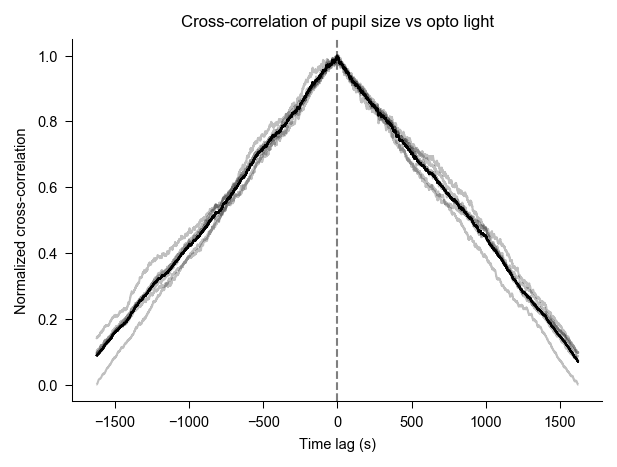

In [121]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(lags.T, corrs.T, 'k', alpha=0.25)
plt.plot(lags.T, corrs_mean, 'k')
ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
# maxcorr = lags[np.where(corr == np.max(corr))[0]]  # find max crosscorr
# ax.axvline(x=maxcorr, ymin=0, ymax=1, color='r', linestyle='--', zorder=-1)
# ax.set_xlim([-1,1])
ax.set_title('Cross-correlation of pupil size vs opto light')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized cross-correlation')  # 'Discrete lin cross-corr'

### Find maximum cross-corr within defined centre time range
-> This identifies the time lag between pupil size and opto by finding the extremum of the xcorr 

In [126]:
trange = [-50, 50]
lags_range = lags[0][(lags[0] >= trange[0]) & (lags[0] < trange[-1])]
corrs_range = corrs_mean[(lags[0] >= trange[0]) & (lags[0] < trange[-1])]
mincorr = corrs_range[np.where(corrs_range == np.min(corrs_range))[0]]  # find max crosscorr
mincorr_t = lags_range[np.where(corrs_range == np.min(corrs_range))[0]]  # find max crosscorr tpoint
mincorr_t

array([45.6])

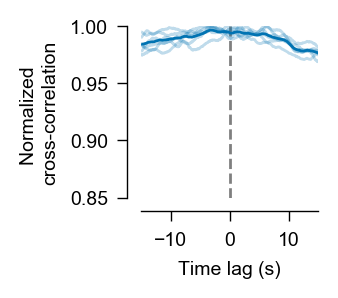

In [131]:
## Plot stimulus-pupil diameter cross-correlation

fig, ax = plt.subplots(figsize=cm2inch((4,3.5)), dpi=200)

ax.plot(lags.T, corrs.T, color=cols['opto'], alpha=0.25)
ax.plot(lags[0], corrs_mean, color=cols['opto'])

ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
# ax.annotate(f'{np.int(maxcorr_t[0]*1000)} ms', xy=(mincorr_t, mincorr-0.02), 
#             xytext=(mincorr_t, mincorr-0.04), ha='left', va='top', size=7,
#             arrowprops=dict(facecolor='black', arrowstyle='->', relpos=(0.5,0.5)))# width=0.05, shrink=0.5))
ax.set_xlim([-15, 15])
ax.set_ylim([0.85,1])
# ax.set_title('Cross-correlation of \nstimulus luminance vs pupil diameter')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized \ncross-correlation')  # 'Discrete lin cross-corr'

adjust_spines(ax, ['bottom', 'left'])

# plt.savefig('eye_stim_luminance_cross_corr.pdf')

Doesn't look like any effect

### Get pupil size vs opto correlation
Now shifting the eye traces by the found delay time.

In [132]:
corrs = np.full(len(df), np.nan)
pvals = np.full(len(df), np.nan)
corrs_null = np.full((len(df),1000), np.nan)
err_list = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:
        corrs[i], pvals[i], corrs_null[i,:] = corr_predictors(key, 'eye', 'opto',
                                                              kind='pearsonr')
        print('.', end='')
    except:
        print('x', end='')
        err_list.append(key)
        continue

# Remove NaNs
pvals = pvals[~np.isnan(corrs)]
corrs_null = corrs_null[~np.isnan(corrs)]
corrs = corrs[~np.isnan(corrs)]
print('\nError list:')
pprint.pprint(err_list)

...xxxxx...
Error list:
[{'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 6},
 {'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 7},
 {'e': 7, 'm': 'Ntsr1Cre_2020_0001', 's': 2},
 {'e': 6, 'm': 'Ntsr1Cre_2020_0001', 's': 3},
 {'e': 10, 'm': 'Ntsr1Cre_2020_0001', 's': 3}]


### Check stats

In [133]:
# Check how many p-vals are significant (two-tailed)
print('Correlation coeffs:\n', np.round(corrs, 3))
print(f'Mean corr coeff ± SD:\n {np.mean(corrs)} ± {np.std(corrs)}')

alpha = 0.001
signif = sum((pvals < alpha) | (pvals > 1-alpha))
print(f'Significant values with p < {alpha}:'
      f'\n {pvals}',
      f'\n => {signif}/{len(pvals)}')

Correlation coeffs:
 [-0.036 -0.023 -0.015 -0.014  0.007  0.019]
Mean corr coeff ± SD:
 -0.010333549547248059 ± 0.018364395237169397
Significant values with p < 0.001:
 [0.062 0.141 0.202 0.267 0.649 0.804] 
 => 0/6


## Stimulus vs stimulus

### Auto-correlation

In [139]:
# Get cross corr for individual experiments
corrs = []
lags = []
err_list = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:
        corr, lag = corr_predictors(key, 'stim', 'stim', 
                                    kind='cross-corr')
        corrs.append(corr), lags.append(lag)
        print('.', end='')
    except:
        print('x', end='')
        err_list.append(key)
        continue
print('\nError list:')
pprint.pprint(err_list)

...xxxxx...
Error list:
[{'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 6},
 {'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 7},
 {'e': 7, 'm': 'Ntsr1Cre_2020_0001', 's': 2},
 {'e': 6, 'm': 'Ntsr1Cre_2020_0001', 's': 3},
 {'e': 10, 'm': 'Ntsr1Cre_2020_0001', 's': 3}]


In [140]:
# Unify experiment-wise cross-corrs of different length into single array
minlag = np.min([i[-1] for i in lags])  # find experiment w smallest lag range
print('minlag = ±', minlag, 's')

# Apply minlag to all experiments to get same trange
for i, l in enumerate(lags):
    corrs[i] = corrs[i][(l >= -minlag) & (l <= minlag)]
    lags[i] = lags[i][(l >= -minlag) & (l <= minlag)]

corrs = np.stack(corrs)
lags = np.stack(lags)

corrs_mean = np.mean(corrs, axis=0)

minlag = ± 1799.9666666666667 s


Text(0, 0.5, 'Normalized auto-correlation')

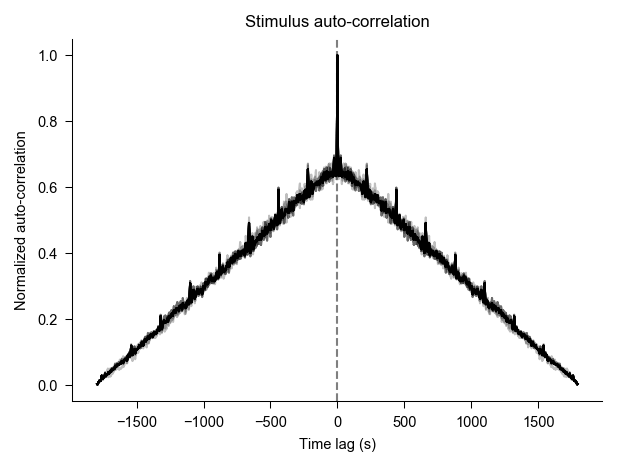

In [142]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.plot(lags.T, corrs.T, 'k', alpha=0.25)
plt.plot(lags.T, corrs_mean, 'k')
ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
# maxcorr = lags[np.where(corr == np.max(corr))[0]]  # find max crosscorr
# ax.axvline(x=maxcorr, ymin=0, ymax=1, color='r', linestyle='--', zorder=-1)
# ax.set_xlim([-1,1])
ax.set_title('Stimulus auto-correlation')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized auto-correlation')  # 'Discrete lin cross-corr'

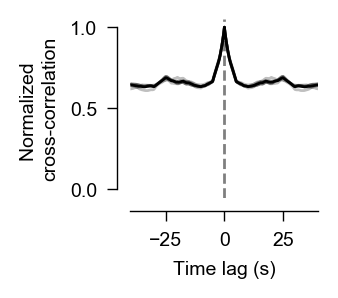

In [153]:
## Plot stimulus-pupil diameter cross-correlation

fig, ax = plt.subplots(figsize=cm2inch((4,3.5)), dpi=200)

ax.plot(lags.T, corrs.T, color='k', alpha=0.25)
ax.plot(lags[0], corrs_mean, color='k')

ax.axvline(x=0, ymin=0, ymax=1, color='k', linestyle='--', alpha=0.5, zorder=-1)
# ax.annotate(f'{np.int(maxcorr_t[0]*1000)} ms', xy=(mincorr_t, mincorr-0.02), 
#             xytext=(mincorr_t, mincorr-0.04), ha='left', va='top', size=7,
#             arrowprops=dict(facecolor='black', arrowstyle='->', relpos=(0.5,0.5)))# width=0.05, shrink=0.5))
ax.set_xlim([-40, 40])
# ax.set_ylim([0.85,1])
# ax.set_title('Cross-correlation of \nstimulus luminance vs pupil diameter')
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Normalized \ncross-correlation')  # 'Discrete lin cross-corr'

adjust_spines(ax, ['bottom', 'left'])

# plt.savefig('eye_stim_luminance_cross_corr.pdf')

## Plot predictor correlation matrix with appropriately time-shifted traces

In [116]:
# If shifting eye trace relative to stimulus by 0.666 and shiftig eye_t relative to run trace by -1.4, then shift run trace by:
shift_run_t = -0.666--1.4
shift_run_t

0.7339999999999999

In [117]:
err_list = []
dfs = []

for i, key in df.head(n=len(df)).iterrows(): # n=len(df)
    key = key.to_dict()
    try:        
        df_corr = predictor_corr_matrix(key, shift_eye_t=-0.666, shift_run_t=shift_run_t)
        dfs.append(df_corr.values)
        print('.', end='')
    except:
        print('x', end='')
        err_list.append(key)
        continue

mean_corr = np.array(dfs).mean(axis=0)
df_mean_corr = pd.DataFrame(mean_corr, columns=df_corr.columns, index=df_corr.index)

print('\nError list:')
pprint.pprint(err_list)

...xxxxx...
Error list:
[{'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 6},
 {'e': 6, 'm': 'Ntsr1Cre_2019_0008', 's': 7},
 {'e': 7, 'm': 'Ntsr1Cre_2020_0001', 's': 2},
 {'e': 6, 'm': 'Ntsr1Cre_2020_0001', 's': 3},
 {'e': 10, 'm': 'Ntsr1Cre_2020_0001', 's': 3}]


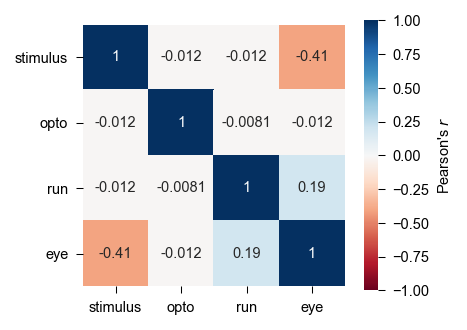

In [164]:
fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax = sns.heatmap(df_mean_corr, cmap='RdBu', center=0, vmin=-1, vmax=1, square=True,
                 annot=True, annot_kws={'fontsize': 7},
                 cbar_kws={'label': "Pearson's $r$", 'shrink':0.6},
                 ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(axis='y', rotation=0)

plt.savefig('predictor_corr_matrix.pdf')